In [1]:
%load_ext autoreload
%autoreload 2

# Загрузка кода при работе через Colab

In [2]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   ! git clone https://github.com/VasilievArtyom/PneumothoraxSegmentation.git
   ! cd PneumothoraxSegmentation

# Установка необходимых библиотек

In [ ]:
! pip install -q -r requirements.txt

# Загрузка данных

In [ ]:
! wget -nc https://fls.avasiliev.xyz/Lectures/PathologySegmentation/SIIM-ACR-Pneumothorax-Segmentation.zip 
! unzip -n -q SIIM-ACR-Pneumothorax-Segmentation.zip

# Структура репозитория PneumothoraxSegmentation

Установим небольшую утилиту `tree`, которая позволит нам удобно визуализировать работу с файлами и папками проекта:

In [ ]:
! apt-get -qq install -y tree

In [60]:
! tree -I 'SIIM-ACR-Pneumothorax-Segmentation*' -I '**__pycache__' ../PneumothoraxSegmentation/

../PneumothoraxSegmentation/
├── configs
│   ├── inference.yaml
│   └── train.yaml
├── datasets
│   ├── inference.py
│   ├── __init__.py
│   ├── train.py
│   └── transforms.py
├── EDA.ipynb
├── Experiments
├── inference_wrapper.py
├── LICENSE
├── losses
│   ├── __init__.py
│   └── loss.py
├── main.ipynb
├── metrics.py
├── models
│   ├── __init__.py
│   └── model.py
├── pl_models.py
├── README.md
├── requirements.txt
├── train_wrapper.py
└── utils
    └── __init__.py

7 directories, 20 files


Как мы видим, репозиторий содержит несколько директорий:
- `configs`, для хранения конфигурационных файлов (подробно обсудим ниже)
- `datasets`, для описание кода-адаптера для работы с нужными нам данными
- `losses`, для хранения самостоятельно написанных функций потерь, если они нам потребуются
- `models`, для хранения базовых классов нейронных сетей
-  кроме того, зарезервирован модуль `utils`, в который можно поместить любой вспомогательный код

## Конфигурационные файлы

Для удобства работы весь процесс обучения контролируется через конфигурационные файлы:

In [4]:
from train_wrapper import load_config

In [5]:
! cat configs/train.yaml

# main paths
data_path: "SIIM-ACR-Pneumothorax-Segmentation"
annotation_path: "SIIM-ACR-Pneumothorax-Segmentation"
exp_path: "Experiments"

# train
annotations: "train.csv"
images: "dicom-images"
masks: "masks"

# validation
val_annotations: "val.csv"
val_images: "dicom-images"
val_masks: "masks"

# exp params
exp_name: baseline
project: SIIM-ACR-Pneumothorax-Segmentation

trainer:
  precision: 32
  sync_batchnorm: True
  gradient_clip_val: 1.0
  max_epochs: 5
  accelerator: auto
  #  accelerator: gpu
  devices: auto
  #  devices: [0]

weights:

model:
  smp_model_name: "Unet"
  kwargs:
    encoder_name: 'tu-tf_efficientnet_b2'
    encoder_weights: 'imagenet'
    in_channels: 3
    classes: 1

dataloader:
  batch_size: 16
  num_workers: 2

preprocess:
  side_size: 512
  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]

transforms:
  - name: 'RandomBrightnessContrast'
    kwargs:
      brightness_by_max: True
      p: 0.5
  - name: 'ImageCompression'
    kwargs:
      quality_lo

In [6]:
train_config = load_config('configs/train.yaml')

In [7]:
train_config

{'data_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'annotation_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'exp_path': 'Experiments',
 'annotations': 'train.csv',
 'images': 'dicom-images',
 'masks': 'masks',
 'val_annotations': 'val.csv',
 'val_images': 'dicom-images',
 'val_masks': 'masks',
 'exp_name': 'baseline',
 'project': 'SIIM-ACR-Pneumothorax-Segmentation',
 'trainer': {'precision': 32,
  'sync_batchnorm': True,
  'gradient_clip_val': 1.0,
  'max_epochs': 5,
  'accelerator': 'auto',
  'devices': 'auto'},
 'weights': None,
 'model': {'smp_model_name': 'Unet',
  'kwargs': {'encoder_name': 'tu-tf_efficientnet_b2',
   'encoder_weights': 'imagenet',
   'in_channels': 3,
   'classes': 1}},
 'dataloader': {'batch_size': 16, 'num_workers': 2},
 'preprocess': {'side_size': 512,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'transforms': [{'name': 'RandomBrightnessContrast',
   'kwargs': {'brightness_by_max': True, 'p': 0.5}},
  {'name': 'ImageCompression',
   '

То есть через конфигурационный файл можно задать путь до данных, какую именно модель учить и какие выбирать параметры оптимизации, относительно какой метрики нужно контролировать процесс переобучения.

## Класс датасета для работы с данными во время обучения

Модуль datasets/train.py реализует класс TrainDataset (наследник `torch.utils.data.Dataset`), у которого реализованы методы `__getitem__` и `__len__`. Описанный TrainDataset ожидает, что у вас есть разметка в для тренировочной и валидационной выборок в формате .csv, а данные представляют собой набор изображений и масок, располагающиеся в отдельных директориях. При работе со своими данными вам будет необходимо адаптировать код датасета под свои нужды.

In [8]:
from datasets.train import TrainDataset
import matplotlib.pyplot as plt

In [9]:
train_ds = TrainDataset(config=train_config)

In [10]:
len(train_ds)

10165

In [11]:
train_ds[0].keys()

dict_keys(['image', 'mask', 'label', 'idx'])

In [12]:
train_ds[0]['image'].shape, train_ds[0]['mask'].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [13]:
train_ds[0]['label']

tensor([1.])

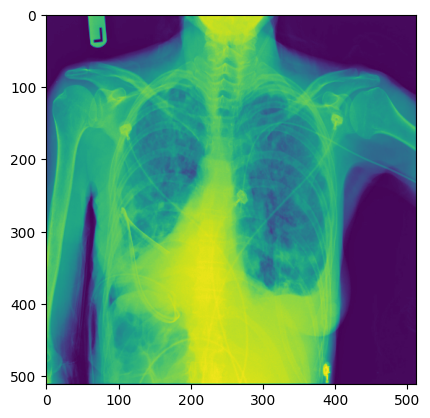

In [14]:
plt.imshow(train_ds[0]['image'][0, ...])

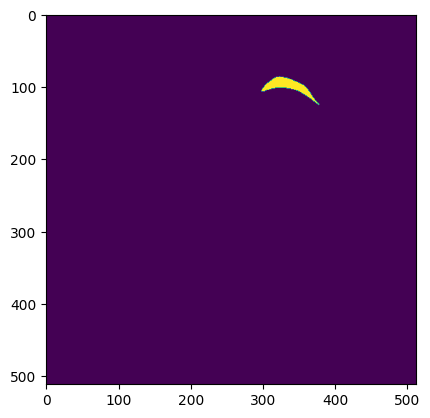

In [17]:
plt.imshow(train_ds[0]['mask'][0, ...])

К исходным данным применяется прдобработка, определенная конфигурационным файлом:

In [18]:
train_config['preprocess']

{'side_size': 512, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

А также к изображениям и маскам сегментации будут применяться согласованные между собой аугментации:

In [19]:
train_config['transforms']

[{'name': 'RandomBrightnessContrast',
  'kwargs': {'brightness_by_max': True, 'p': 0.5}},
 {'name': 'ImageCompression',
  'kwargs': {'quality_lower': 99,
   'quality_upper': 100,
   'compression_type': 0,
   'p': 0.1}},
 {'name': 'HorizontalFlip', 'kwargs': {'p': 0.5}}]

Заметим, что TrainDataset предоставляет для нас данные сразу в пригодном для отправки в нейронную сеть виде. Изображения нормализованы:

(array([141917.,  39931.,  22170.,  47394.,  88076., 123414., 127901.,
         89209.,  80559.,  25861.]),
 array([-2.0836544 , -1.68797743, -1.29230046, -0.89662343, -0.50094646,
        -0.10526949,  0.29040748,  0.68608445,  1.08176148,  1.47743845,
         1.87311542]),
 <BarContainer object of 10 artists>)

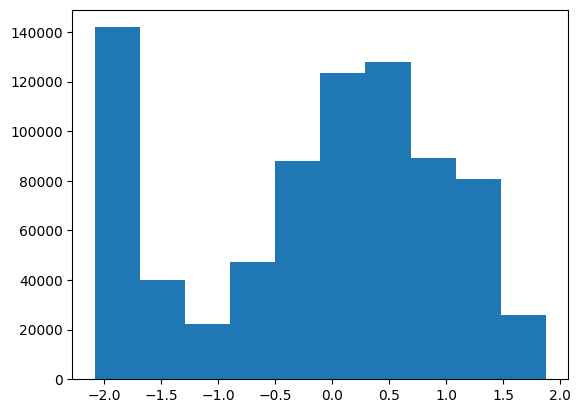

In [20]:
plt.hist(train_ds[0]['image'].flatten())

In [21]:
train_ds[0]['image'].dtype, train_ds[0]['mask'].dtype, train_ds[0]['label'].dtype 

(torch.float32, torch.float32, torch.float32)

## Создание модели из конфигурационного файла

Мы будем использовать сегментационные модели из библиотеки segmentation_models_pytorch (smp):
- [github](https://github.com/qubvel-org/segmentation_models.pytorch)
- [Документация smp](https://smp.readthedocs.io/en/latest/)

In [22]:
train_config['model']

{'smp_model_name': 'Unet',
 'kwargs': {'encoder_name': 'tu-tf_efficientnet_b2',
  'encoder_weights': 'imagenet',
  'in_channels': 3,
  'classes': 1}}

В нашем коде уже реализован класс, который создаёт экземпляр модели на основе текстовой конфигурации:

In [23]:
from models.model import TorchModel

In [24]:
model = TorchModel(train_config['model'])

In [25]:
import torch

In [26]:
B, C, H, W = 4, 3, 512, 512 
dummy_input = torch.randn(B, C, H, W)
pred_mask, pred_label = model(dummy_input)

In [27]:
pred_mask.shape

torch.Size([4, 1, 512, 512])

In [28]:
pred_label.shape

torch.Size([4])

Модель возвращает предсказанную маску сегментации в сыром виде (логиты), а также выход классификатора (так же в виде логитов).

## Комбинированная функция потерь для сегментации и классификации

In [29]:
from losses.loss import TorchLoss

In [30]:
! cat losses/loss.py

from torch import nn


class TorchLoss(nn.Module):
    def __init__(self, cls_coef = 0.1):
        super().__init__()
        self.segmentation_loss = nn.BCEWithLogitsLoss()
        self.cls_loss = nn.BCEWithLogitsLoss()
        self.cls_coef = cls_coef

    def forward(
        self, 
        preds_mask, preds_label,
        target_mask, target_label
    ):
        segmentation_loss = self.segmentation_loss(preds_mask, target_mask)
        cls_loss = self.cls_loss(preds_label, target_label)
        return segmentation_loss + self.cls_coef * cls_loss

In [31]:
loss = TorchLoss()

loss_value = loss(
    preds_mask=pred_mask,
    preds_label=pred_label,
    target_mask=torch.randn(B, 1, H, W),
    target_label=torch.randn(B)
)

In [32]:
loss_value

tensor(0.9953, grad_fn=<AddBackward0>)

## Создание PyTorch Lightning пайплайна из конфигурационного файла

Полезно иметь код для обучения и инференса моделей стандартизованным и избежать возможных ошибок при описании собственных train loop, взаимодействии кода с графическими ускорителями и, что самое главное, при вычислении метрик. Мы настоятельно рекомендуем пользоваться экосистемой фремворка [[git] 🐾 PyTorch Lightning](https://github.com/Lightning-AI/pytorch-lightning) и при обучении моделей использовать метрики качества из [[git] 🐾 Torchmetrics](https://github.com/Lightning-AI/torchmetrics).

In [33]:
from pl_models import TrainPipeline

In [34]:
pipeline = TrainPipeline(train_config, [], []);

In [35]:
pipeline.config

{'data_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'annotation_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'exp_path': 'Experiments',
 'annotations': 'train.csv',
 'images': 'dicom-images',
 'masks': 'masks',
 'val_annotations': 'val.csv',
 'val_images': 'dicom-images',
 'val_masks': 'masks',
 'exp_name': 'baseline',
 'project': 'SIIM-ACR-Pneumothorax-Segmentation',
 'trainer': {'precision': 32,
  'sync_batchnorm': True,
  'gradient_clip_val': 1.0,
  'max_epochs': 5,
  'accelerator': 'auto',
  'devices': 'auto'},
 'weights': None,
 'model': {'smp_model_name': 'Unet',
  'kwargs': {'encoder_name': 'tu-tf_efficientnet_b2',
   'encoder_weights': 'imagenet',
   'in_channels': 3,
   'classes': 1}},
 'dataloader': {'batch_size': 16, 'num_workers': 2},
 'preprocess': {'side_size': 512,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'transforms': [{'name': 'RandomBrightnessContrast',
   'kwargs': {'brightness_by_max': True, 'p': 0.5}},
  {'name': 'ImageCompression',
   '

При создании пайплайна автоматически создаются соответствующие конфигурационному файлу модель сегментации, создаются экземпляры объектов для вычисления метрик качества, функция потерь и оптимизатор: 

In [36]:
pipeline.criterion

TorchLoss(
  (segmentation_loss): BCEWithLogitsLoss()
  (cls_loss): BCEWithLogitsLoss()
)

In [37]:
pipeline.train_classification_metrics

MetricCollection(
  (BinaryAUROC): BinaryAUROC(),
  postfix=/classification/train
)

In [38]:
pipeline.train_segmentation_metrics

MetricCollection(
  (BinaryJaccardIndex): BinaryJaccardIndex(),
  postfix=/segmentation/train
)

# Обучение модели

Будем следить за процессом обучения при помощи tensorboard

In [ ]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
    %load_ext tensorboard
    %tensorboard --logdir {train_config['exp_path']} --port 6006

Загружаем конфигурацию обучения:

In [39]:
from train_wrapper import load_config

In [41]:
train_config = load_config('configs/train.yaml')
train_config

{'data_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'annotation_path': 'SIIM-ACR-Pneumothorax-Segmentation',
 'exp_path': 'Experiments',
 'annotations': 'train.csv',
 'images': 'dicom-images',
 'masks': 'masks',
 'val_annotations': 'val.csv',
 'val_images': 'dicom-images',
 'val_masks': 'masks',
 'exp_name': 'baseline',
 'project': 'SIIM-ACR-Pneumothorax-Segmentation',
 'trainer': {'precision': 32,
  'sync_batchnorm': True,
  'gradient_clip_val': 1.0,
  'max_epochs': 5,
  'accelerator': 'auto',
  'devices': 'auto'},
 'weights': None,
 'model': {'smp_model_name': 'Unet',
  'kwargs': {'encoder_name': 'tu-tf_efficientnet_b2',
   'encoder_weights': 'imagenet',
   'in_channels': 3,
   'classes': 1}},
 'dataloader': {'batch_size': 16, 'num_workers': 2},
 'preprocess': {'side_size': 512,
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225]},
 'transforms': [{'name': 'RandomBrightnessContrast',
   'kwargs': {'brightness_by_max': True, 'p': 0.5}},
  {'name': 'ImageCompression',
   '

Конфигурационный файл можно передать в функцию, которая создаст экземпляры lightning пайплайна и запустит процесс обучения:

In [42]:
from train_wrapper import train

Мы установили параметр `max_epochs=5` для экономии времени при тестовом запуске. На практике необходимо установить значительно большее число эпох для достижения приемлемого качества.

In [43]:
train(train_config)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A5000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline/metrics
2024-12-04 02:18:49.193812: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-04 02:18:49.221007: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 02:18:49.221038: E exte

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Тестирование обученной модели

Для тестирования нашей модели мы завели аналогичный по структуре конфигурационный файл, который описывает какую именно обученную модель и на каких данных необходимо запустить:

In [44]:
! cat configs/inference.yaml

# main paths
data_path: "SIIM-ACR-Pneumothorax-Segmentation"
annotation_path: "SIIM-ACR-Pneumothorax-Segmentation"

# annotation paths
annotations: "test.csv"
images: "dicom-images"
masks: "masks"

# exp params
save_path: "Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline"
test_name: test

trainer:
  precision: 32
  accelerator: auto
  #  accelerator: gpu
  devices: auto
  #  devices: [0]

weights: "Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline/model.ckpt"
model:
  smp_model_name: "Unet"
  kwargs:
    encoder_name: 'tu-tf_efficientnet_b2'
    encoder_weights: 'imagenet'
    in_channels: 3
    classes: 1

dataloader:
  batch_size: 128
  num_workers: 2

preprocess:
  side_size: 512
  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]

transforms:


In [45]:
from inference_wrapper import load_config, inference

In [46]:
inference_config = load_config('configs/inference.yaml')

## Получение масок сегментации на тестовых данных:

На предыдущем этапе мы сохранили веса обученной модели и логи обучения на диск:

In [47]:
! tree Experiments/

Experiments/
└── SIIM-ACR-Pneumothorax-Segmentation
    └── baseline
        ├── last.ckpt -> /home/av/proj/mfk/PneumothoraxSegmentation/Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline/model.ckpt
        ├── metrics
        │   └── version_0
        │       ├── events.out.tfevents.1733267930.mainframe.33367.0
        │       └── hparams.yaml
        └── model.ckpt

5 directories, 4 files


Запустим модель с лучшей метрикой качества на валидационных данных:

In [54]:
inference(inference_config)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

Результат запуска модели на тестовых данных сохраняется на диск в виде таблицы с предсказаниями и предсказанных масок:

In [55]:
! tree Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline

Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline
├── last.ckpt -> /home/av/proj/mfk/PneumothoraxSegmentation/Experiments/SIIM-ACR-Pneumothorax-Segmentation/baseline/model.ckpt
├── metrics
│   └── version_0
│       ├── events.out.tfevents.1733267930.mainframe.33367.0
│       └── hparams.yaml
├── model.ckpt
└── test
    ├── 0.png
    ├── 1.png
    ├── 2.png
    ├── 3.png
    ├── 4.png
    ├── 5.png
    ├── 6.png
    ├── 7.png
    ├── 8.png
    ├── 9.png
    └── predictions.csv

4 directories, 15 files


## Визуализация результатов

In [56]:
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import pydicom

In [57]:
gt_df = pd.read_csv('SIIM-ACR-Pneumothorax-Segmentation/test.csv')
pred_df = pd.read_csv(
    Path(inference_config['save_path']) /
    Path(inference_config['test_name']) /
    Path('predictions.csv')
)

test_results_df = pd.concat([gt_df,pred_df], axis=1)

In [58]:
test_results_df[['idx', 'PNTX', 'label']]

,idx,PNTX,label
0,0,1.0,0.587011
1,1,0.0,0.149716
2,2,1.0,0.198782
3,3,0.0,0.202717
4,4,0.0,0.058151
5,5,1.0,0.700445
6,6,1.0,0.699507
7,7,0.0,0.222748
8,8,1.0,0.635538
9,9,0.0,0.033039


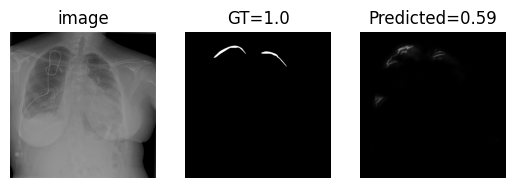

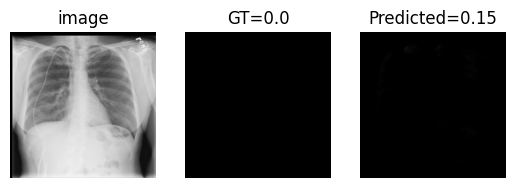

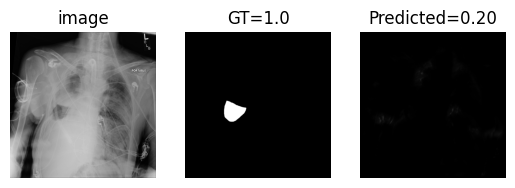

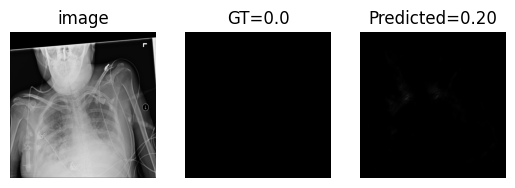

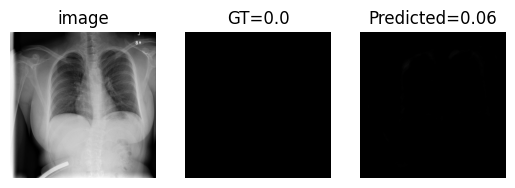

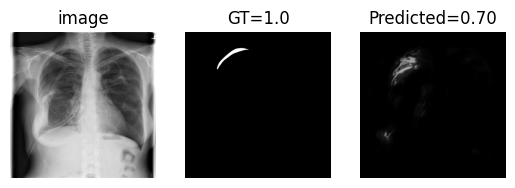

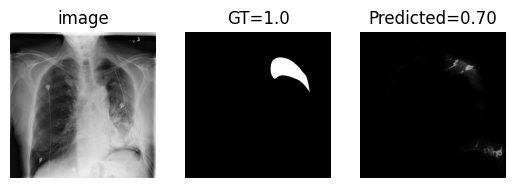

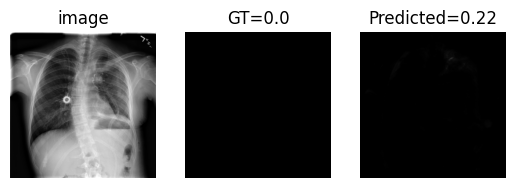

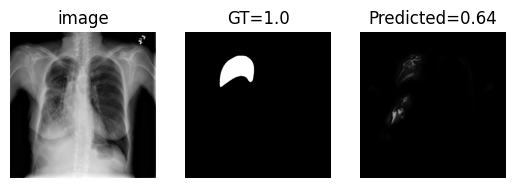

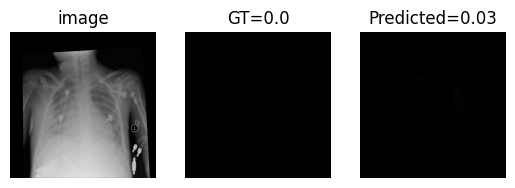

In [59]:
def plot_gt_vs_pred(
    dcm, gt_mask, pred_mask,
    gt_label, pred_label
):
    image = dcm.pixel_array
    pred_mask = cv.resize(
        pred_mask,
        dcm.pixel_array.shape[::-1],
        cv.INTER_NEAREST
    )
    fix, ax = plt.subplots(ncols=3)
    for ax_i, title, pic in zip(
        ax,
        ['image', f'GT={gt_label}', f'Predicted={pred_label:0.2f}'],
        [image, gt_mask, pred_mask]
    ):
        ax_i.set_axis_off()
        ax_i.set_title(title)
        ax_i.imshow(
            pic, aspect='equal', cmap='gray',
             vmin=0, vmax=255
        )
    plt.show()
    
for idx, row in test_results_df.iterrows():
    dcm = pydicom.dcmread(
        Path('SIIM-ACR-Pneumothorax-Segmentation/dicom-images/')/
        Path(row.sop_path)
    )
    
    gt_mask = cv.imread(str(
        Path('SIIM-ACR-Pneumothorax-Segmentation/masks/')/
        Path(row.mask_path)
    ), cv.IMREAD_GRAYSCALE)
    
    pred_mask = cv.imread(str(
        Path(inference_config['save_path']) /
        Path(inference_config['test_name']) /
        Path(f'{row.idx}.png')
    ), cv.IMREAD_GRAYSCALE)

    plot_gt_vs_pred(
        dcm, gt_mask, pred_mask,
        row.PNTX, row.label
    )